# Ex5: Variational quantum eigensolver

## Part 1:  VQE for H$_2$ molecule

In [2]:
from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [17]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐                    ┌──────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■────■─────────■──┤ RY(θ[8]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘┌─┴─┐  │         │  └──────────┘»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├────────────┤ X ├──┼────■────┼───────■──────»
     └──┬───┬───┘├──────────┤┌──────────┐└───┘┌─┴─┐┌─┴─┐  │       │      »
q_2: ───┤ X ├────┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼──────»
     ┌──┴───┴───┐├──────────┤└──────────┘     └───┘└───┘┌─┴─┐   ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├───────────────────────────┤ X ├───┤ X ├────»
     └──────────┘└──────────┘                           └───┘   └───┘    »
«     ┌───────────┐                                         ┌───────────┐»
«q_0: ┤ RZ(θ[12]) ├───────────────────■────────■─────────■──┤ RY(θ[16]) ├»
«     └┬──────────┤┌───────────┐    ┌─┴─┐      │         │  └───────────┘»
«q_1: ─┤ RY(θ[9]) ├┤ RZ(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────»
«      └──────────┘├─────

In [22]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [23]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.8533636186720404
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


In [24]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 500,
    'eigenstate': array([ 5.55839219e-07+4.33667242e-05j, -2.54817228e-04+1.69136374e-04j,
       -1.41198727e-05+1.07852951e-05j, -2.98933473e-05+3.34001403e-05j,
       -9.30756867e-06-2.69271113e-06j,  9.59165537e-01+2.59526293e-01j,
        4.01826666e-04-2.39628624e-04j, -6.72818471e-08+1.34512394e-07j,
        3.66141410e-08-2.52535990e-08j, -7.66350067e-04+4.00786325e-04j,
       -1.08531209e-01-2.94523377e-02j,  8.41316477e-05-1.50598909e-05j,
        3.82451399e-06-3.01452469e-06j,  1.24046236e-04-9.64048191e-05j,
       -3.11599148e-05-1.51052025e-05j, -1.17678002e-04+1.17115410e-05j]),
    'eigenvalue': -1.8533628495566552,
    'optimal_parameters': {   ParameterVectorElement(θ[12]): 0.9182692041658823,
                              ParameterVectorElement(θ[21]): 1.1822559282436655,
                              ParameterVectorElement(θ[0]): 0.22539103122433168,
                              ParameterVecto

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"[ry, rz]",cx,full,3,0.000769,True,18


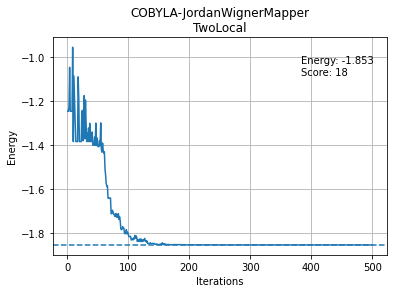

In [25]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_thresholdaccuract_thres,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

## Part 2: Final Challenge - VQE for LiH molecule

In [26]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [27]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer
# decreases the # of qubits
freezeCT = [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])]
problem = ElectronicStructureProblem(driver,q_molecule_transformers=freezeCT)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

In [28]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
# given in hints above
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

# given in hints above
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

In [29]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


In [30]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled
    # full -> linear : 18 -> 6    
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    # 3 -> 2 : 18 -> 6
    repetitions = 2
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤                    └───┘        ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────────────────┤ X ├────»
     └──────────┘└──────────┘                                 └───┘    »
«                                         
«q_0: ───────────────────■────────────────
«     ┌───────────┐    ┌─┴─┐              
«q_1: ┤ RZ(θ[13]) ├────┤ X ├──────■───────
«     ├───────────┤┌───┴───┴───┐┌─┴─┐     
«q_2: ┤ RY(θ[10]) ├┤ RZ(θ[14]) ├┤ X ├──■──
«     ├───────────┤├───────────┤└───┘┌─┴─┐
«q_3: ┤ RY(θ[11]) ├┤ RZ(θ[15]) ├─────┤ X ├

In [31]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

# random choice
optimizer_type = 'SLSQP'

if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [32]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347446
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [33]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 904,
    'eigenstate': array([-2.48120350e-04+2.19558308e-04j, -4.64118849e-05-7.61814102e-05j,
        8.48218208e-03+2.86073731e-05j,  9.90116625e-01+5.24045117e-02j,
        5.66916888e-04+2.11604924e-05j,  2.87706978e-06+1.75972248e-06j,
       -1.81984375e-02+2.53728163e-04j, -2.35606271e-02+2.29886740e-04j,
        2.69193977e-03-2.64559956e-05j,  2.43952337e-05+2.42111933e-05j,
       -1.30937537e-03+5.78743910e-05j, -4.95458974e-03-1.84939327e-04j,
       -1.13374747e-01-5.99460783e-03j, -3.32051450e-04-2.48022862e-05j,
        5.49914169e-02+2.74220273e-03j,  2.32411554e-03-1.90760028e-03j]),
    'eigenvalue': -1.0865874787632486,
    'optimal_parameters': {   ParameterVectorElement(θ[12]): -6.294420571217223e-05,
                              ParameterVectorElement(θ[11]): 1.249966783255469,
                              ParameterVectorElement(θ[13]): -0.011732851275143612,
                              Paramete

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3,0.000769,True,18
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,2,2.118537,True,6


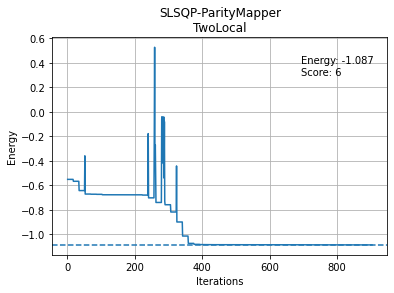

In [34]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

## By INNAN Nouhaila